In [13]:
#General processing and visualization libraries
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

#for the dendogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
from fastdtw import fastdtw
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

#Set the style of the visualizations
plt.style.use("seaborn")

#Ignore some warnings for readability
import warnings
warnings.filterwarnings('ignore')

In [14]:
#Import the data
file_path = r"C:\Users\annie\Desktop\uni\thesis\Bookings_Sunweb_Sun_NL.csv" #replace with your own
data = pd.read_csv(file_path, delimiter=";")

#Remove data when no destination airport is given
data = data[data["DestinationAirport"]!="0"] 

# Make two distinct columns for departure and booking : week and year
data[['DepartureYear', 'DepartureWeek']] = data["DepartureYearWeek"].str.split('_', expand=True).apply(pd.to_numeric)
data[['BookingYear', 'BookingWeek']] = data["BookingYearWeek"].str.split('_', expand=True).apply(pd.to_numeric)

# Compute total passengers per holiday package and add columnn "Pax_total"
data = data.merge(
    data.groupby(["DestinationAirport", "DepartureYearWeek"], as_index=False)['Pax'].sum().rename(columns={'Pax': 'Pax_total'}),
    on=["DestinationAirport", "DepartureYearWeek"]
)

#Remove all holiday packages departing on the 53rd week of any year (Note:2015 was a leap year)
data = data[~(data["DepartureWeek"] == 53)]

#Remove all bookings made in the 53rd week of any year 
data = data[~(data["BookingWeek"] == 53)]

#Create percent column : representing the percent of bookings made in a specific booking week 
data['percent'] = data['Pax'] / data["Pax_total"]

def calculate_weeks_in_advance(row):
    '''
    Given a row, calculate how many weeks in advance of the departure week was that booking made. 
    Parameters:
    - row : one row of the dataframe
    Returns :
    - number that represents the weeks in advance 
    '''
    # If the booking and departure are in the same year, simply subtract the booking week from the departure week
    if row["DepartureYear"] == row["BookingYear"]:
        return row["DepartureWeek"] - row["BookingWeek"]
    else:
        # If the booking and departure span different years, calculate the weeks in advance by accounting for the full years and weeks difference
        return (row["DepartureYear"] - row["BookingYear"]) * 52 - (row["BookingWeek"] - row["DepartureWeek"])

# Apply the function calculate_weeks_in_advance to create a new column 'advance' representing the weeks in advance 
data["advance"] = data.apply(calculate_weeks_in_advance, axis=1)

In [15]:
# Filter data for weeks before 2018_44 : training set 
data_in_x_train = data[data["DepartureYearWeek"] <= "2018 _ 44"]

In [16]:
def make_X(data):
    '''
    Generate a DataFrame that is indexed per holiday package with the following columns:
    1. DestinationCountry: The country of the destination airport. e.g. "Spain"
    2. DestinationAirport: The code of the destination airport.  e.g. "ACE"
    3. DepartureYearWeek: The combination of the departure year and week. e.g. "2015 _ 51"
    4. DepartureYear: The year of departure. e.g. 2015
    5. DepartureWeek: The week of departure.  e.g. 51
    6. Pax_total: The total number of passengers.  e.g. 243
    7. BookingsList: An array of length 104 representing the percent of bookings made for each booking week in advance.
       E.g., at index 0: 0.0041 means 0.41% of the total bookings were made 0 weeks in advance(same week as departure).
    8. WeekList: An array of length 104 representing the booking week of the year when the booking occurred.
        E.g., at index 0: 51, the week of departure is booking week 51 , at index 1: 50 , 1 week before departure is booking week 50
        
    Note: The lists come in handy for reducing the high-dimensionality of the data instead of having one row per booking week,
    there is one row per holiday package 
    
    Parameters:
    - data: The input DataFrame containing the booking data
    Returns:
    - df: The generated DataFrame with the specified columns with the lists, indexed by each holiday package
    '''
    
    result = []

    # A unique holiday package is defined as a combination of destination airport and departure year-week
    holiday_packages = data.groupby(['DestinationAirport', 'DepartureYearWeek'])

    # Iterate through each unique holiday package
    for (destination, dep), destination_data in holiday_packages:
        # Filter the data for the current destination and departure year-week
        destination_data = data[(data['DestinationAirport'] == destination) & (data["DepartureYearWeek"] == dep)]

        week_numbers = []  # Initialize a list to hold the week numbers in descending order
        number = destination_data["DepartureWeek"].iloc[0]  # The starting point for the booking weeks is the departure week

        # Create a descending list of the booking weeks
        while len(week_numbers) < 104:  # Considering a 2-year horizon, hence 104 weeks
            week_numbers.append(number)  # Append the current number to the list
            number -= 1  # Decrement the current number to get the next week in descending order
            if number == 0:  # If the current number reaches 0, restart from week 52 (end of the year)
                number = 52

        bookings_per_week = np.zeros(104)  # Initialize an array to track bookings for the 104-week horizon, starting with zero bookings

        # Fill the bookings array with the booking percentages
        for index, row in destination_data.iterrows():
            advance = row["advance"]  # Calculate the number of weeks in advance the booking was made
            bookings_per_week[advance] = row['percent']  # Set the booking percentage for the corresponding week in advance

        # Append the results for the current holiday package to the result list
        result.append([
            row['DestinationCountry'],  # Country of the destination
            destination,  # Destination airport
            dep,  # Departure year-week
            row['DepartureYear'],  # Departure year
            row['DepartureWeek'],  # Departure week
            row['Pax_total'],  # Total number of passengers
            list(bookings_per_week),  # List of bookings per week
            week_numbers  # List of week numbers in descending order
        ])

    # Create a DataFrame from the result list with appropriate column names
    df = pd.DataFrame(result, columns=[
        'DestinationCountry', 'DestinationAirport', 'DepartureYearWeek', 
        'DepartureYear', 'DepartureWeek', 'Pax_total', 
        'BookingsList', "WeekList"
    ])

    return df

# Call the function make_X
df = make_X(data)

#add column of either high or low volume holiday package based on the predetermined value of 50 passengers
df["Passenger_Status"] = np.where(df["Pax_total"] >= 50, "high", "low")

# Calculate the accumulated sum in reverse chronological order (from latest to earliest)
# for each list in 'BookingsList' and assign the result to 'AccumulatedList'.
df["AccumulatedList"] = df["BookingsList"].apply(lambda x: np.cumsum(x[::-1])[::-1])

In [17]:
def calculate_weeks_in_advance(row):
    '''
    For each holiday package include the same list of the weeks in advance
    This will just be an 104-element, ascending list in this form [0,1,2..103] 
    Note: This is not necessary but can help with calculations later.
    Parameters:
    - row: a row of a dataframe.
    Returns:
    - row : the new row with the new column "Advance"
        '''
    row["Advance"] = [(i % 104) for i in range(len(row["BookingsList"]))] 
    return row

#create a simple "weeks in advance" column 
df = df.apply(calculate_weeks_in_advance, axis=1)

#add column of either high or low volume holiday package based on the predetermined value of 50 passengers
df["Passenger_Status"] = np.where(df["Pax_total"] >= 50, "high", "low")

#add a column with the accumulate bookings per week: the first element should be the value 1 (adding up all the percentages)
#this is easier to plot
df["AccumulatedList"] = df["BookingsList"].apply(lambda x: np.cumsum(x[::-1])[::-1])

#### Figure 3.1

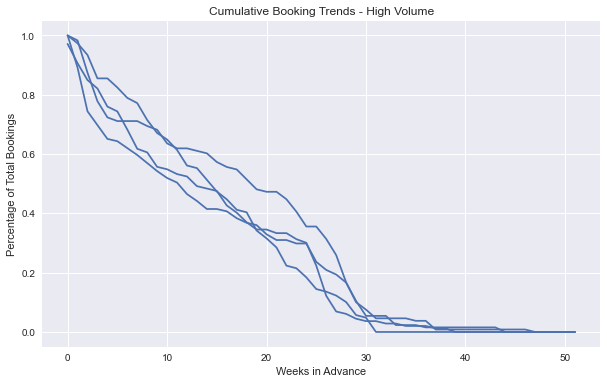

In [18]:
# Filter rows where DestinationAirport is "ACE" and DepartureWeek is 30 (this is a high volume destination for 4 years)
high_volume_example = df[(df["DestinationAirport"] == "ACE") & (df["DepartureWeek"] == 30)]

# Limit the length of "AccumulatedList" and "Advance" columns to 52 first weeks
high_volume_example["AccumulatedList"] = high_volume_example["AccumulatedList"].apply(lambda x: x[:52])
high_volume_example["Advance"] = high_volume_example["Advance"].apply(lambda x: x[:52])

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Iterate over rows in high_volume_example DataFrame
for index, row in high_volume_example.iterrows():
    # Plot a line graph for each row, using "Advance" as x-axis and "AccumulatedList" as y-axis
    sns.lineplot(data=row, x="Advance", y="AccumulatedList", color='#4c72b0')

# Set labels and title for the plot
plt.xlabel("Weeks in Advance")
plt.ylabel("Percentage of Total Bookings")
plt.title("Cumulative Booking Trends - High Volume")

plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\highvol.jpg", quality=95, dpi=500)

plt.show()


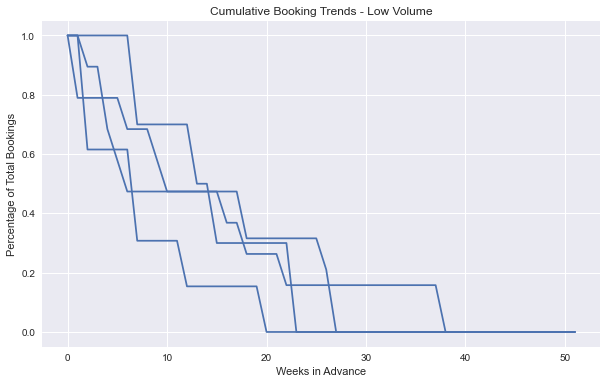

In [19]:
# Filter rows where DestinationAirport is "LCA" and DepartureWeek is 26
low_volume_example= df[(df["DestinationAirport"] == "LCA") & (df["DepartureWeek"] == 26)]

# Limit the length of "AccumulatedList" and "Advance" columns to 52 characters
low_volume_example["AccumulatedList"] = low_volume_example["AccumulatedList"].apply(lambda x: x[:52])
low_volume_example["Advance"] = low_volume_example["Advance"].apply(lambda x: x[:52])

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Iterate over rows in low1 DataFrame
for index, row in low_volume_example.iterrows():
    # Plot a line graph for each row, using "Advance" as x-axis and "AccumulatedList" as y-axis
    sns.lineplot(data=row, x="Advance", y="AccumulatedList", color='#4c72b0')

# Set labels and title for the plot
plt.xlabel("Weeks in Advance")
plt.ylabel("Percentage of Total Bookings")
plt.title("Cumulative Booking Trends - Low Volume")

plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\lowvol.jpg", quality=95, dpi=500)


# Display the plot
plt.show()

#### Figure 4.1

Percentage of bookings in the first 3 weeks: 21.06%


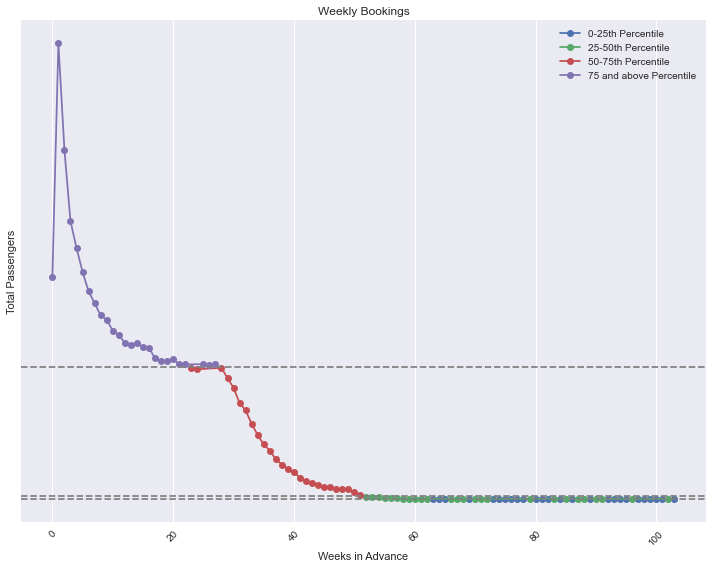

In [20]:
# Calculate total weekly bookings for each week in advance
weekly_bookings = data_in_x_train.groupby("advance")["Pax"].sum().reset_index()

# Create a DataFrame with all options for weeks in advance (0 to 103) - equivalent to 2 years
all_weeks_in_advance = pd.DataFrame({'advance': range(104)})  

# Merge to ensure all weeks are represented, filling missing values with 0
weekly_bookings_complete = all_weeks_in_advance.merge(weekly_bookings, on='advance', how='left').fillna(0).astype({'Pax': int})

# Calculate percentiles
percentiles = np.percentile(weekly_bookings_complete["Pax"], [25, 50, 75])

# Categorize weeks based on percentiles using numpy's digitize function
weekly_bookings_complete['category'] = np.digitize(weekly_bookings_complete["Pax"], bins=percentiles)

# Plotting
plt.figure(figsize=(10, 8))

# Define percentile categories and corresponding colors
percentile_colors = {
    0: {'label': '0-25th Percentile', 'color': '#4c72b0'},
    1: {'label': '25-50th Percentile', 'color': '#55a868'},
    2: {'label': '50-75th Percentile', 'color': '#c44e52'},
    3: {'label': '75 and above Percentile', 'color': '#8172b2'}
}

# Plot each percentile category
for category, info in percentile_colors.items():
    weeks = weekly_bookings_complete[weekly_bookings_complete['category'] == category]['advance']
    bookings = weekly_bookings_complete[weekly_bookings_complete['category'] == category]['Pax']
    plt.plot(weeks, bookings, color=info['color'], marker='o', linestyle='-', label=info['label'])

# Plot percentile lines in gray
for p in percentiles:
    plt.axhline(p, color='gray', linestyle='--')

# Plot settings
plt.title('Weekly Bookings')
plt.xlabel('Weeks in Advance')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks([])
plt.legend()
plt.tight_layout()

plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\dummies.jpg", quality=95, dpi=500)


# Calculate percentage of bookings in the first 3 weeks relative to total bookings
print("Percentage of bookings in the first 3 weeks:", f"{(weekly_bookings_complete[weekly_bookings_complete['advance'] <= 3]['Pax'].sum() / weekly_bookings_complete['Pax'].sum() * 100):.2f}%")


#### Figure 4.2

In [21]:
# Define X_train using dataframe df
X_train = df[
    (
        ((df["DepartureYear"] > 2015) & (df["DepartureYear"] < 2018)) | 
        ((df["DepartureYear"] == 2015) & (df["DepartureWeek"] >= 44)) |
        ((df["DepartureYear"] == 2018) & (df["DepartureWeek"] <= 44))
    )
]


In [22]:
#Need to compute the benchmark model by averaging past booking patterns for each of the 52 departure weeks to plot dendogram

# Group the training data by 'DepartureWeek'
grouped_dep_week = X_train.groupby(["DepartureWeek"])

# Create an empty DataFrame with columns for each departure week, the bookings list, and the week list
average_df = pd.DataFrame(columns=["DepartureWeek", "BookingsList", "WeekList"])

# Iterate through each group of departure weeks
for i, (index, group) in enumerate(grouped_dep_week):
    
    # Assign the current departure week to the DataFrame
    average_df.loc[i, "DepartureWeek"] = index
    
    # Convert the 'BookingsList' column of the current group to a numpy array
    bookings_list_array = np.array(group["BookingsList"].tolist())
    
    # Calculate the average bookings by summing the array along axis 0 and dividing by the number of groups
    average_bookings = np.sum(bookings_list_array, axis=0) / len(group) 
    
    # Normalize the average bookings so that the sum of the bookings equals 1
    normalized_average_bookings = average_bookings / np.sum(average_bookings)
    
    # Assign the normalized average bookings to the DataFrame
    average_df.loc[i, "BookingsList"] = normalized_average_bookings
    
    # Assign the 'WeekList' from the first entry of the current group to the DataFrame
    average_df.loc[i, "WeekList"] = group["WeekList"].iloc[0] 


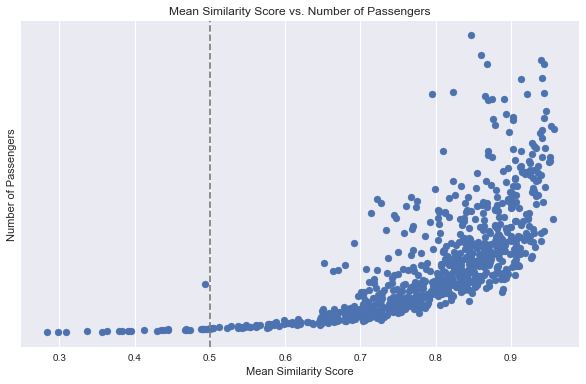

 Pax_total  SimilarityScore
         1         0.297936
         2         0.282870
         3         0.308070
         4         0.356331
         5         0.337226
         6         0.362907
         7         0.378572
         8         0.383551
         9         0.391550
        10         0.429725
        11         0.395153
        12         0.412574
        13         0.434882
        14         0.444255
        15         0.469987
        16         0.467333
        17         0.438863
        18         0.473807
        19         0.443967
        20         0.495668
        21         0.491375
        22         0.468694
        23         0.491710
        24         0.489228
        25         0.499892
        26         0.488166
       354         0.493502


In [33]:
# Function to calculate cosine similarity
def calculate_similarity(pattern, average_pattern):
    return cosine_similarity([pattern], [average_pattern])[0][0]

# Compute similarity for each row in X_train based on the corresponding average pattern
similarities = []
for i, row in X_train.iterrows():
    departure_week = row['DepartureWeek']
    pattern = row['BookingsList']
    avg_pattern = average_df[average_df['DepartureWeek'] == departure_week]['BookingsList'].values[0]
    similarity_score = calculate_similarity(pattern, avg_pattern)
    similarities.append(similarity_score)

# Store the similarity scores in X_train
X_train['SimilarityScore'] = similarities

# Group by the number of passengers and calculate the mean similarity score for each group
mean_similarity_per_passenger = X_train.groupby('Pax_total')['SimilarityScore'].mean().reset_index()

# Plot the mean similarity score against the number of passengers
plt.figure(figsize=(10, 6))
plt.scatter(mean_similarity_per_passenger['SimilarityScore'], mean_similarity_per_passenger['Pax_total'], marker='o')
plt.axvline(x=0.5, color="gray", linestyle='--')
plt.title('Mean Similarity Score vs. Number of Passengers')
plt.ylabel('Number of Passengers')
plt.xlabel('Mean Similarity Score')
plt.yticks([])
plt.grid(True)

plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\meansimilarity.jpg", quality=95, dpi=500)

plt.show()

# Filter rows where the similarity score is below the threshold (0.5)
below_threshold = mean_similarity_per_passenger[mean_similarity_per_passenger['SimilarityScore'] < 0.5]

# Print the rows where the similarity score is below the threshold
print(below_threshold.to_string(index=False))


#### Figure 5.2

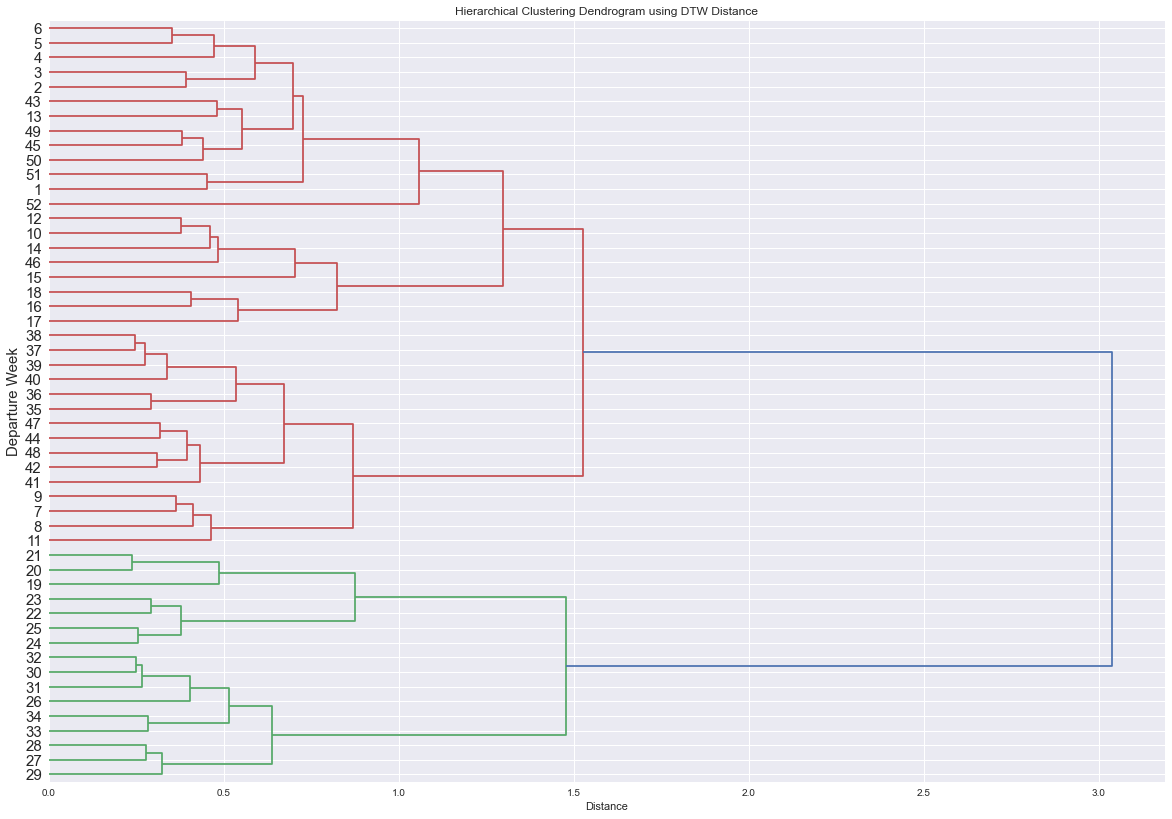


Best number of clusters: 8, Best silhouette score: 0.16435912249745172
[20, 21, 22, 23, 24, 25, 26]
[32, 33, 34]
[27, 28, 29, 30, 31]
[2, 3, 4, 5, 6, 43, 45, 49, 50]
[16, 17, 18, 19]
[1, 51, 52]
[10, 11, 12, 13, 14, 15, 44, 46, 47, 48]
[7, 8, 9, 35, 36, 37, 38, 39, 40, 41, 42]


In [25]:
# Convert 'BookingsList' from average_df into a numpy array and then a DataFrame
bookings_list = np.array(average_df['BookingsList'].tolist())
df_bookings = pd.DataFrame(bookings_list)

# Compute the distance matrix using DTW distance
distance_matrix = pdist(df_bookings, metric=lambda u, v: fastdtw(u, v)[0])
distance_matrix = squareform(distance_matrix)

# Perform hierarchical clustering using Ward's method
Z = linkage(distance_matrix, method='ward')

# Plot the dendrogram horizontally
plt.figure(figsize=(20, 14))
dendrogram(Z, labels=average_df['DepartureWeek'].astype(str).tolist(), leaf_rotation=0, orientation='right')

# Adjust labels font size
plt.tick_params(axis='y', labelsize=15)  # Increase font size of departure week labels

plt.title('Hierarchical Clustering Dendrogram using DTW Distance')
plt.xlabel('Distance')
plt.ylabel('Departure Week', fontsize=15)  # Increase ylabel font size


plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\dendogram.jpg", quality=95, dpi=500)

plt.show()

# Your data for clustering (replace with your actual data)
departure_weeks = average_df['DepartureWeek']

# Initialize variables to store results
best_num_clusters = 0
best_silhouette_score = -1
best_clusters = None

# Perform silhouette analysis for different numbers of clusters
for num_clusters in range(3, 11):
    # Perform hierarchical clustering
    Z = linkage(bookings_list, method='ward')
    
    # Assign data points to clusters
    clusters = fcluster(Z, num_clusters, criterion='maxclust')
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(bookings_list, clusters)
    
    # Update the best silhouette score and number of clusters if needed
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_num_clusters = num_clusters
        best_clusters = clusters

# Print the best number of clusters and its silhouette score
print(f"\nBest number of clusters: {best_num_clusters}, Best silhouette score: {best_silhouette_score}")

# Extract departure weeks for each cluster
departure_weeks_by_cluster = {cluster: [] for cluster in range(1, best_num_clusters + 1)}
for idx, cluster in enumerate(best_clusters):
    departure_week = departure_weeks.iloc[idx]
    departure_weeks_by_cluster[cluster].append(departure_week)

# Print departure weeks for each cluster
for cluster, weeks in departure_weeks_by_cluster.items():
    print(weeks)


#### Appendix A

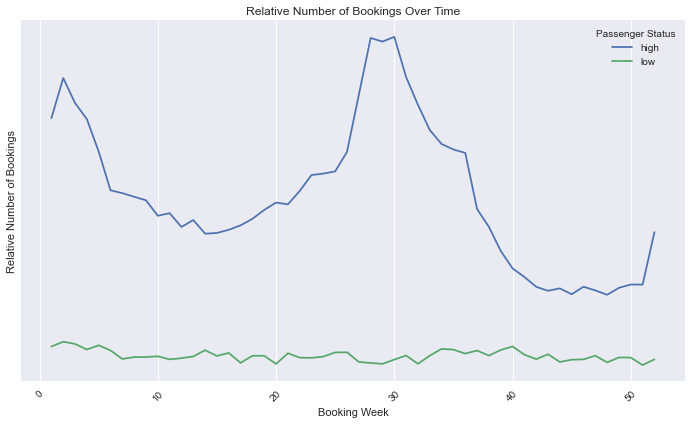

In [26]:
# Calculate total bookings for high and low passenger statuses separately
total_high_bookings = data_in_x_train[data_in_x_train["Passenger_Status"] == "high"]["Pax"].sum()
total_low_bookings = data_in_x_train[data_in_x_train["Passenger_Status"] == "low"]["Pax"].sum()

# Plotting
plt.figure(figsize=(10, 6))

# Plot relative bookings for high passenger status
sns.lineplot(data=data_in_x_train, x="BookingWeek", y=data_in_x_train["Pax"] / total_high_bookings, hue="Passenger_Status", ci=None, palette={'high': '#4c72b0', 'low': '#55a868'})

# Adding labels and title
plt.xlabel('Booking Week')
plt.ylabel('Relative Number of Bookings')
plt.title('Relative Number of Bookings Over Time')
plt.legend(title='Passenger Status', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.yticks([])

plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\relative_bookings.jpg", quality=95, dpi=500)

plt.show()


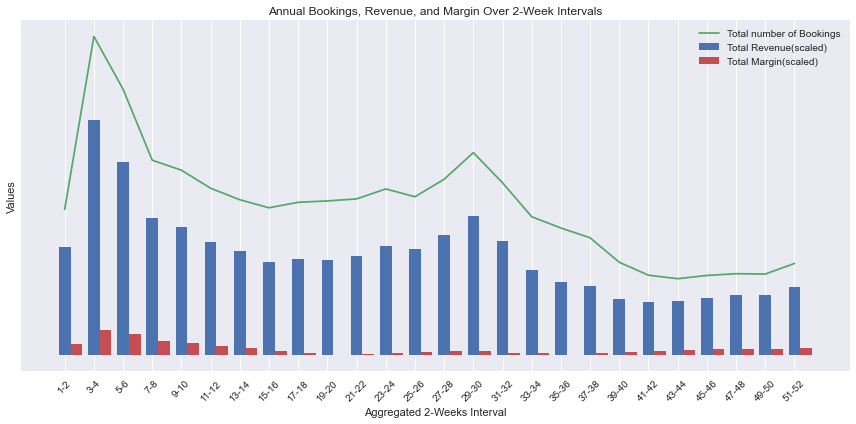

In [27]:
#Define Booking data
booking_data = data_in_x_train[['BookingWeek', "Pax", "Revenue", "Margin"]]

# Define the bin edges for the booking weeks
bin_edges = np.arange(0, 53, 2)

# Group data into bins and aggregate per 4 weeks
grouped_booking_data = booking_data.groupby(pd.cut(booking_data['BookingWeek'], bins=bin_edges, right=False)).agg({'Pax': 'sum', 'Revenue': 'sum', 'Margin': 'sum'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot bookings as a line plot
plt.plot(range(len(grouped_booking_data)), grouped_booking_data ['Pax'], color="#55a868", label='Total number of Bookings')

# Plot revenue as a bar plot
# Note: the values were divided by 1000 for illustrative purposes
plt.bar(range(len(grouped_booking_data)), grouped_booking_data ['Revenue'] / 1000, width=0.4, color="#4c72b0", label='Total Revenue(scaled)')

# Plot margin as a bar plot next to revenue
# Note: the values were divided by 1000 for illustrative purposes
plt.bar([x + 0.4 for x in range(len(grouped_booking_data))], grouped_booking_data['Margin'] / 1000, width=0.4, color='#c44e52', label='Total Margin(scaled)')

# Formatting
plt.title('Annual Bookings, Revenue, and Margin Over 2-Week Intervals')
plt.xlabel('Aggregated 2-Weeks Interval')
plt.ylabel('Values')
plt.legend()
plt.xticks(range(len(grouped_booking_data)), [f"{i*2 + 1}-{i*2 + 2}" for i in range(len(grouped_booking_data))], rotation=45)
plt.yticks([])
plt.tight_layout()

plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\annual bookings.jpg", quality=95, dpi=500)

plt.show()


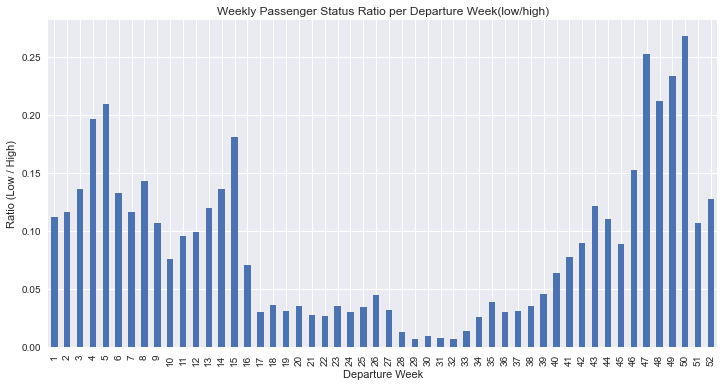

In [28]:
# Group by DepartureWeek and Passenger_Status, summing up the Passengers
grouped_dep = data.groupby(['DepartureWeek', 'Passenger_Status'])['Pax'].sum().unstack()

# Calculate the ratio of low to high packages for each week
grouped_dep['Ratio'] = grouped_dep['low'] / grouped_dep['high']

# Plotting
plt.figure(figsize=(12, 6))
grouped_dep['Ratio'].plot.bar()

# Add labels and title
plt.title('Weekly Passenger Status Ratio per Departure Week(low/high)')
plt.xlabel('Departure Week')
plt.ylabel('Ratio (Low / High)')

plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\ratio.jpg", quality=95, dpi=500)


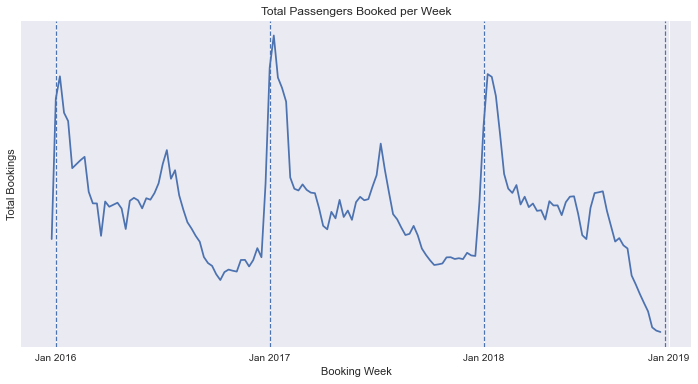

In [29]:
# Grouping and summing passengers per week
weekly_passengers_sum = data_in_x_train.groupby("BookingYearWeek")["Pax"].sum().reset_index().sort_values(by="BookingYearWeek", ascending=True)

# Filtering data for years from 2015 week 52 to 2018 week 52
weekly_passengers_sum = weekly_passengers_sum[(weekly_passengers_sum["BookingYearWeek"] >= "2015 _ 52")]

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=weekly_passengers_sum, x="BookingYearWeek", y="Pax")

# Adding vertical lines for start of each year
for year in range(2015, 2019):
    start_of_year = str(year) + " _ 01"
    plt.axvline(start_of_year, linestyle='--', linewidth=1.2)

# Hide x and y axis values
custom_labels = ["Jan 2016", "Jan 2017", "Jan 2018", "Jan 2019"]
plt.xticks(["2016 _ 01", "2017 _ 01", "2018 _ 01", "2019 _ 01"], custom_labels)
plt.yticks([])


# Adding labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('Total Passengers Booked per Week')
plt.xlabel("Booking Week")
plt.ylabel("Total Bookings")

plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\bookingweeks.jpg", quality=95, dpi=500)

plt.show()


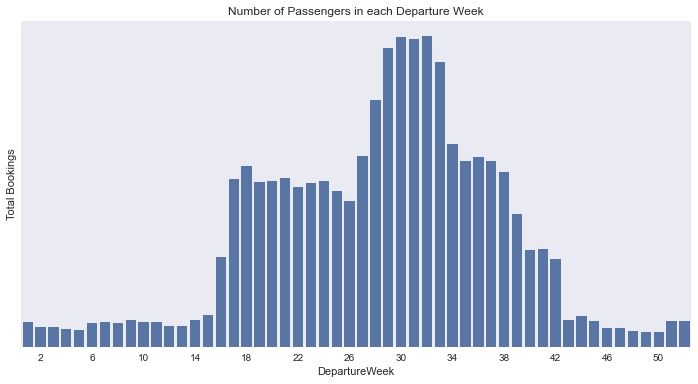

In [30]:
# Group data by "DepartureWeek" and sum the "Pax" column
dep_group = data_in_x_train.groupby("DepartureWeek")["Pax"].sum().reset_index()

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Create a bar plot using seaborn
sns.barplot(data=dep_group, y="Pax", x="DepartureWeek", color='#4c72b0')

# Set the title and labels for the plot
plt.title('Number of Passengers in each Departure Week')
plt.xlabel("DepartureWeek")
plt.ylabel("Total Bookings")

# Remove y-axis ticks
plt.yticks([])

# Set x-axis ticks to show labels every 4 weeks
plt.xticks(ticks=dep_group["DepartureWeek"][::4])

plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\departureweekstotal.jpg", quality=95, dpi=500)

# Display the plot
plt.show()


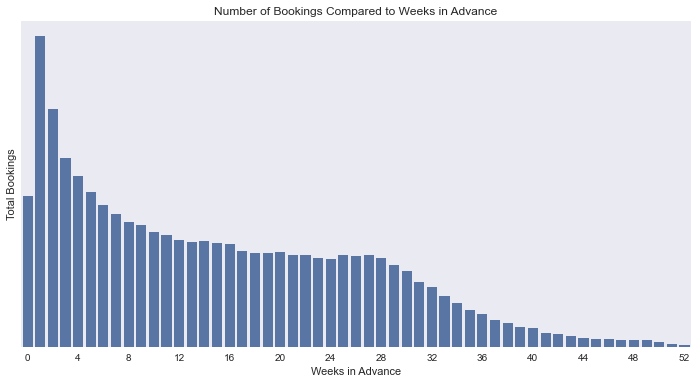

In [31]:
# Group data by "advance" and sum the "Pax" column
advance_group = data_in_x_train.groupby("advance")["Pax"].sum().reset_index()

# Filter to include only weeks up to week 52
advance_group = advance_group[advance_group["advance"] <= 52]

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Create a bar plot using seaborn
sns.barplot(data=advance_group, y="Pax", x="advance", color='#4c72b0')

# Set the title and labels for the plot
plt.title('Number of Bookings Compared to Weeks in Advance')
plt.xlabel("Weeks in Advance")
plt.ylabel("Total Bookings")

# Remove y-axis ticks
plt.yticks([])

# Set x-axis ticks to show labels every 4 weeks
plt.xticks(ticks=advance_group["advance"][::4])

plt.savefig(r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder 1\advance.jpg", quality=95, dpi=500)

# Display the plot
plt.show()
